
Training phase: Joint
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4668
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4258
Epoch 0: XOR Loss 1.0694, AND Loss 1.0871, Total Entropy 5.7200
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4766
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4515
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4808
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4646
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4799
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4717
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4771
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4762
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0007, max 0.4747
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0003, max 0.4779
Step 0: attn_probs shape torch.Size([

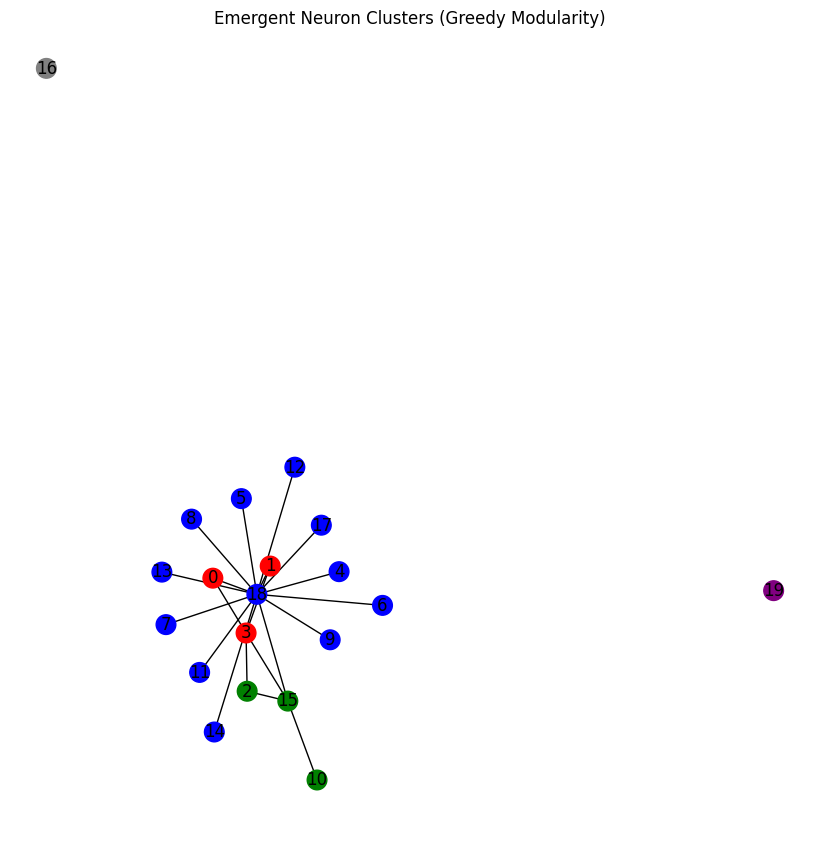

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

class BrainInspiredNet(nn.Module):
    def __init__(self, num_neurons, embed_dim):
        super().__init__()
        self.num_neurons = num_neurons
        self.embed_dim = embed_dim

        # --- ADD THESE LINES HERE ---
        # Fix 1: Input projector to create rich embeddings from 1D inputs
        self.input_proj = nn.Linear(1, embed_dim) 
        
        # Fix 2: Learnable initial states for all neurons
        self.neuron_states = nn.Embedding(num_neurons, embed_dim)
        # --- END OF ADDED LINES ---

        self.W_query = nn.Linear(embed_dim, embed_dim)
        self.W_key = nn.Linear(embed_dim, embed_dim)
        self.W_value = nn.Linear(embed_dim, embed_dim)
        
        self.output_proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
        )
        self.norm = nn.LayerNorm(embed_dim)

        # --- ALSO ADD INITIALIZATION FOR THE NEW LAYERS ---
        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.xavier_uniform_(self.neuron_states.weight)
        # --- END OF ADDED INITIALIZATION ---

        nn.init.xavier_uniform_(self.W_query.weight)
        nn.init.xavier_uniform_(self.W_key.weight)
        nn.init.xavier_uniform_(self.W_value.weight)
        nn.init.xavier_uniform_(self.output_proj[0].weight)
        nn.init.xavier_uniform_(self.output_proj[2].weight)

    def forward(self, input_neurons, input_values, output_neurons, steps=20):
        batch_size = input_values.size(0)
        # Create a batch of initial states from the learnable embeddings
        states = self.neuron_states.weight.unsqueeze(0).repeat(batch_size, 1, 1)
        for i, neuron in enumerate(input_neurons):
            # Project the 1D input value to embed_dim
            input_embedding = self.input_proj(input_values[:, i].unsqueeze(-1))
            # Add it to the state (soft injection) instead of replacing
            states[:, neuron, :] = states[:, neuron, :] + input_embedding

        total_entropy = 0.0
        attn_probs_all = []
        l1_attn = 0.0
        for step in range(steps):
            states = self.norm(states)
            queries = self.W_query(states)
            keys = self.W_key(states)
            values = self.W_value(states)
            attn_logits = torch.matmul(queries, keys.transpose(-2, -1)) / (self.embed_dim ** 0.5)
            # Add epsilon to prevent numerical issues
            attn_probs = F.softmax(attn_logits + 1e-8, dim=-1)
            # Check for NaN/infinity
            if torch.isnan(attn_probs).any() or torch.isinf(attn_probs).any():
                print(f"Step {step}: NaN or Inf in attn_probs")
                return None, None, None, None
            # if step % 20 == 0:
            #     print(f"Step {step}: attn_probs shape {attn_probs.shape}, min {attn_probs.min().item():.4f}, "
            #         f"max {attn_probs.max().item():.4f}")
            attn_probs_all.append(attn_probs)
            entropy = - (attn_probs * torch.log(attn_probs + 1e-8)).sum(-1).mean()
            total_entropy += entropy
            l1_attn += attn_probs.abs().sum()
            new_states = torch.matmul(attn_probs, values)
            # Add the residual connection *first*
            states = states + new_states
            # Apply activation
            states = F.relu(states)
            # Apply normalization *after* the update
            states = self.norm(states)
        if not attn_probs_all:
            print("Error: attn_probs_all is empty")
            return None, None, None, None
        outputs = self.output_proj(states[:, output_neurons, :]).squeeze(-1)
        avg_entropy = total_entropy / steps
        avg_l1_attn = l1_attn / steps
        attn_probs_avg = torch.stack(attn_probs_all).mean(dim=0)
        return outputs, avg_entropy, attn_probs_avg, avg_l1_attn

# Fisher Information
def compute_fisher(model, input_neurons, input_values, output_neurons, labels):
    model.zero_grad()
    outputs, _, _, _ = model(input_neurons, input_values, output_neurons)
    if outputs is None:
        print("Fisher computation failed due to invalid forward pass")
        return {}
    loss = F.binary_cross_entropy_with_logits(outputs.squeeze(), labels)
    loss.backward(create_graph=True)
    fisher = {n: p.grad.pow(2).detach() for n, p in model.named_parameters() if p.grad is not None}
    grad_norm = sum((p.grad ** 2).sum() for p in model.parameters() if p.grad is not None) ** 0.5
    print(f"Fisher grad norm: {grad_norm.item():.4f}")
    model.zero_grad()
    return fisher

# Setup
num_neurons = 20
embed_dim = 32
model = BrainInspiredNet(num_neurons, embed_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4000)

# Toy data
xor_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
xor_labels = torch.tensor([0., 1., 1., 0.], dtype=torch.float32)
and_inputs = torch.tensor([[-1.,-1.], [-1.,1.], [1.,-1.], [1.,1.]], dtype=torch.float32)
and_labels = torch.tensor([0., 0., 0., 1.], dtype=torch.float32)

xor_in_neurons = [0, 1]
xor_out_neurons = [2]
and_in_neurons = [3, 4]
and_out_neurons = [5]

ewc_lambda = 50.0
prev_fisher = None
prev_params = None

# Training loop
for phase in ["xor", "and", "joint"]:
    print("\nTraining phase: Joint")
    for epoch in range(3000): # Train for longer
        optimizer.zero_grad()
        
        # XOR pass
        xor_outputs, xor_entropy, _, _ = model(xor_in_neurons, xor_inputs, xor_out_neurons)
        if xor_outputs is None:
            print("Forward pass failed for XOR")
            break
        xor_loss = F.binary_cross_entropy_with_logits(xor_outputs.squeeze(), xor_labels)
        
        # AND pass
        and_outputs, and_entropy, _, _ = model(and_in_neurons, and_inputs, and_out_neurons)
        if and_outputs is None:
            print("Forward pass failed for AND")
            break
        and_loss = F.binary_cross_entropy_with_logits(and_outputs.squeeze(), and_labels)
        
        # Simplified loss
        task_loss = xor_loss + and_loss
        entropy_loss = 0.3 * (xor_entropy + and_entropy)
        param_l1_loss = 0.001 * sum(p.abs().sum() for p in model.parameters())

        # No EWC, no attn_l1_loss
        full_loss = task_loss + entropy_loss + param_l1_loss
        
        # No retain_graph=True needed
        full_loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        if epoch % 800 == 0:
            print(f"Epoch {epoch}: XOR Loss {xor_loss.item():.4f}, AND Loss {and_loss.item():.4f}, "
                f"Total Entropy {(xor_entropy + and_entropy).item():.4f}")

# Inference
with torch.no_grad():
    xor_preds, _, _, _ = model(xor_in_neurons, xor_inputs, xor_out_neurons)
    and_preds, _, _, _ = model(and_in_neurons, and_inputs, and_out_neurons)
    if xor_preds is None or and_preds is None:
        print("Inference failed due to invalid forward pass")
    else:
        print("XOR Preds:", torch.sigmoid(xor_preds.squeeze()))
        print("AND Preds:", torch.sigmoid(and_preds.squeeze()))

# Visualization
def get_attention_graph(model, input_neurons, input_values, output_neurons):
    with torch.no_grad():
        outputs, _, attn_probs, _ = model(input_neurons, input_values, output_neurons)
        if attn_probs is None:
            print("Cannot generate graph: invalid attn_probs")
            return nx.Graph()
        print("attn_probs shape:", attn_probs.shape)
        attn_matrix = attn_probs.mean(dim=0).cpu().numpy()
        print("attn_matrix shape:", attn_matrix.shape)
        print("attn_matrix min/max:", attn_matrix.min(), attn_matrix.max())
        attn_matrix = (attn_matrix - attn_matrix.min()) / (attn_matrix.max() - attn_matrix.min() + 1e-8)
    G = nx.Graph()
    k = 20
    edges = []
    for i in range(model.num_neurons):
        for j in range(i + 1, model.num_neurons):
            edges.append((i, j, attn_matrix[i, j]))
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    
    for i in range(model.num_neurons):
        G.add_node(i)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)
    return G

G = get_attention_graph(model, xor_in_neurons, xor_inputs, xor_out_neurons)
pos = nx.spring_layout(G, seed=42)
communities = greedy_modularity_communities(G, weight='weight')
partition = {}
for cluster_id, comm in enumerate(communities):
    for node in comm:
        partition[node] = cluster_id
print("Detected clusters:", partition)

plt.figure(figsize=(8, 8))
colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
node_colors = [colors.get(partition.get(i, 0), 'gray') for i in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=200, with_labels=True)
plt.title("Emergent Neuron Clusters (Greedy Modularity)")
plt.show()

The visualization is based on the attention graph derived from attn_probs, where edges are added only if the attention probability between neurons exceeds a threshold (0.05).

In [2]:
from networkx.algorithms.community import modularity

def find_best_k(model, input_neurons, input_values, output_neurons, min_k=20, max_k=60, step=10):
    best_k = min_k
    best_modularity = -1
    for k in range(min_k, max_k + 1, step):
        G = get_attention_graph(model, input_neurons, input_values, output_neurons, k=k)  # Modify function to take k
        communities = greedy_modularity_communities(G, weight='weight')
        if communities:
            partition = {node: i for i, comm in enumerate(communities) for node in comm}
            current_modularity = modularity(G, communities, weight='weight')
            print(f"k={k}: Modularity = {current_modularity:.4f}")
            if current_modularity > best_modularity:
                best_modularity = current_modularity
                best_k = k
    print(f"Best k: {best_k} with modularity {best_modularity:.4f}")
    return best_k

Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0000, max 1.0000
attn_probs shape: torch.Size([4, 20, 20])
attn_matrix shape: (20, 20)
attn_matrix min/max: 8.4690015e-09 0.4619277
k=20: Modularity = 0.3224
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0000, max 1.0000
attn_probs shape: torch.Size([4, 20, 20])
attn_matrix shape: (20, 20)
attn_matrix min/max: 8.4690015e-09 0.4619277
k=30: Modularity = 0.2347
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0000, max 1.0000
attn_probs shape: torch.Size([4, 20, 20])
attn_matrix shape: (20, 20)
attn_matrix min/max: 8.4690015e-09 0.4619277
k=40: Modularity = 0.1906
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0000, max 1.0000
attn_probs shape: torch.Size([4, 20, 20])
attn_matrix shape: (20, 20)
attn_matrix min/max: 8.4690015e-09 0.4619277
k=50: Modularity = 0.1771
Step 0: attn_probs shape torch.Size([4, 20, 20]), min 0.0000, max 1.0000
attn_probs shape: torch.Size([4, 20, 20])
attn_matrix shape: (20, 20)
a

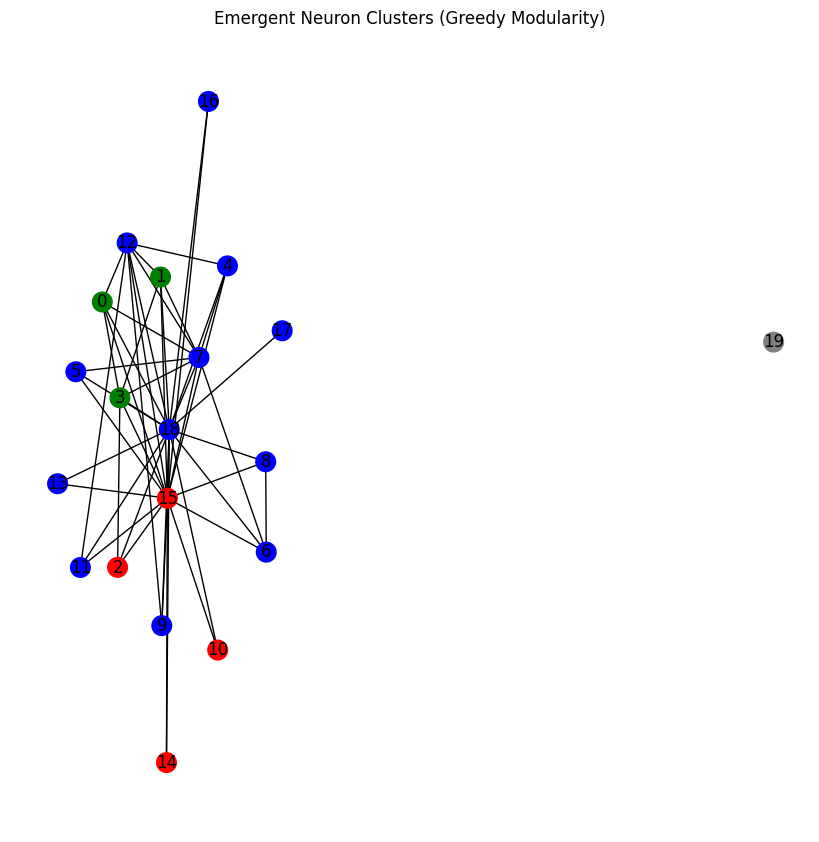

In [3]:
def get_attention_graph(model, input_neurons, input_values, output_neurons, k=50):
    with torch.no_grad():
        outputs, _, attn_probs, _ = model(input_neurons, input_values, output_neurons)
        if attn_probs is None:
            print("Cannot generate graph: invalid attn_probs")
            return nx.Graph()
        print("attn_probs shape:", attn_probs.shape)
        attn_matrix = attn_probs.mean(dim=0).cpu().numpy()
        print("attn_matrix shape:", attn_matrix.shape)
        print("attn_matrix min/max:", attn_matrix.min(), attn_matrix.max())
        attn_matrix = (attn_matrix - attn_matrix.min()) / (attn_matrix.max() - attn_matrix.min() + 1e-8)
    G = nx.Graph()
    edges = []
    for i in range(model.num_neurons):
        for j in range(i + 1, model.num_neurons):
            edges.append((i, j, attn_matrix[i, j]))
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:k]
    
    for i in range(model.num_neurons):
        G.add_node(i)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)
    return G


best_k = find_best_k(model, xor_in_neurons, xor_inputs, xor_out_neurons)

G = get_attention_graph(model, xor_in_neurons, xor_inputs, xor_out_neurons)
pos = nx.spring_layout(G, seed=42)
communities = greedy_modularity_communities(G, weight='weight')
partition = {}
for cluster_id, comm in enumerate(communities):
    for node in comm:
        partition[node] = cluster_id
print("Detected clusters:", partition)

plt.figure(figsize=(8, 8))
colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
node_colors = [colors.get(partition.get(i, 0), 'gray') for i in G.nodes()]
nx.draw(G, pos, node_color=node_colors, node_size=200, with_labels=True)
plt.title("Emergent Neuron Clusters (Greedy Modularity)")
plt.show()

In [4]:
import plotly.graph_objects as go

def visualize_3d(G, pos, partition):
    # Generate 3D positions (use spring_layout with dim=3 or random)
    pos_3d = nx.spring_layout(G, dim=3, seed=42)

    # Edge traces
    edge_x, edge_y, edge_z = [], [], []
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]

    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=2, color='gray'), hoverinfo='none')

    # Node traces
    node_x, node_y, node_z = [], [], []
    node_colors = []
    colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'gray', 4: 'purple', 5: 'orange'}
    for node in G.nodes():
        x, y, z = pos_3d[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_colors.append(colors.get(partition.get(node, 0), 'gray'))

    node_trace = go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers+text', marker=dict(size=10, color=node_colors, opacity=0.8),
                              text=list(G.nodes()), hoverinfo='text')

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title='3D Emergent Neuron Clusters', scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z')))
    fig.show()

# Call after partition
visualize_3d(G, pos, partition)